In [111]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example)

In [241]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
# sub lists I've been using to explore FR1 

# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus
# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
subs = ['R1065J'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1048E','R1054J','R1345D','R1328E','R1308T',
#         'R1137E','R1136N','R1094T','R1122E','R1385E'] # nice example FR1 subs. Both have electrode_categories in pwanda scratch too
# subs = ['R1048E']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:6]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
369,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...,protocols/r1/subjects/R1065J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1065J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1065J/localizations/0/m...,NaN,0,R1065J,R1065J,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...
370,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...,protocols/r1/subjects/R1065J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1065J/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1065J/localizations/0/m...,NaN,1,R1065J,R1065J,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...
371,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...,protocols/r1/subjects/R1065J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1065J/experiments/FR1/s...,0,NaN,2,protocols/r1/subjects/R1065J/localizations/0/m...,NaN,2,R1065J,R1065J,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...
372,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...,protocols/r1/subjects/R1065J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1065J/experiments/FR1/s...,0,NaN,3,protocols/r1/subjects/R1065J/localizations/0/m...,NaN,3,R1065J,R1065J,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...
373,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...,protocols/r1/subjects/R1065J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1065J/experiments/FR1/s...,0,NaN,4,protocols/r1/subjects/R1065J/localizations/0/m...,NaN,4,R1065J,R1065J,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...
374,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...,protocols/r1/subjects/R1065J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1065J/experiments/FR1/s...,0,NaN,5,protocols/r1/subjects/R1065J/localizations/0/m...,NaN,5,R1065J,R1065J,NaN,protocols/r1/subjects/R1065J/experiments/FR1/s...


In [243]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df[404:413]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(554, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2149,NaN,protocols/r1/subjects/R1462M/experiments/FR1/s...,protocols/r1/subjects/R1462M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1462M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1462M/localizations/0/m...,NaN,0,R1462M,R1462M,3.4,protocols/r1/subjects/R1462M/experiments/FR1/s...
2151,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,0,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,0,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2152,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,1,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,1,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2166,NaN,protocols/r1/subjects/R1466J/experiments/FR1/s...,protocols/r1/subjects/R1466J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1466J/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1466J/localizations/0/m...,NaN,0,R1466J,R1466J,3.4,protocols/r1/subjects/R1466J/experiments/FR1/s...


## Load CLUSTER data

In [244]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)
selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
recall_type_switch = 6
    # (1 and 3 are basically opposites...those with a subsequent recall and those without)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolatead recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period (opposite of 4)
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 8: take only 2nd recalls
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
remove_soz_ictal = False
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []

electrode_labels = []; channel_coords = []; channel_nums = []

# for seed in np.arange(44448,44499):
#     print(seed); ripple_array = []; sub_names = []

# Makes most sense to take half the subjects 
if exp == 'FR1':
    np.random.seed(44462) # seed 44462 gives 25,845 of 60,417 recall trials (42.8%). Or 57/167 (34.1% of subs)
    from SWRmodule import total_sub_names_FR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_FR1)
    proportion_subs = 0.5 # it's really 0.5 of initial pre-localization.pairs subs. So comes out to numbers above. And what we want to match for catFR1
elif exp == 'catFR1':
    np.random.seed(44455) # seed 44455 gives 20,393 of 50,053 recall trials (40.7%). Or 47/136 (34.6% of subs)
    from SWRmodule import total_sub_names_catFR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_catFR1)
    proportion_subs = 0.35 # 0.5
random_half_sub_names = np.random.permutation(np.unique(total_sub_names))[:int(np.floor(len(np.unique(total_sub_names))*proportion_subs))]
random_half_sub_names[:10] # just to see them
random_half_sub_names[-10:]
half_sub_idxs = np.array(findAinB(random_half_sub_names,exp_df.subject))
half_df = exp_df.iloc[half_sub_idxs]

# # these subjects failed to work in ClusterRun for whole_retrieval...probably can delete this it was more of a check to understand fr_array/ripple_array mismatch issue
# half_df = half_df[ ((df.subject!='R1083J') | (df.session!=3)) & 
#                 ((df.subject!='R1342M') | (df.session!=1)) ]



for row in half_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP

    
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+'_'+soz_label+'.p') 
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            if selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
            if selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']) # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array'])
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])

    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
# loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)
subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)
if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>0
        
    subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
    session_name_array = np.array(session_name_array)[temp_recall_idxs]
    electrode_array = np.array(electrode_array)[temp_recall_idxs]
    channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
    channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
    ripple_array = np.array(ripple_array)[temp_recall_idxs]
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
    rectime_array = np.array(rectime_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for catFR1
    print('% of recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for catFR1

array(['R1325C', 'R1310J', 'R1077T', 'R1288P', 'R1044J', 'R1108J',
       'R1002P', 'R1131M', 'R1316T', 'R1215M'], dtype='<U6')

array(['R1306E', 'R1137E', 'R1105E', 'R1048E', 'R1138T', 'R1122E',
       'R1094T', 'R1236J', 'R1120E', 'R1338T'], dtype='<U6')

2020-12-24_01-41-34: DF Exception: Sub: R1243T, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1243T_3_HPC_surrounding_recall_soz_in.p', file: <ipython-input-244-db782503f972>, line no: 78
2020-12-24_01-41-35: DF Exception: Sub: R1316T, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1316T_0_HPC_surrounding_recall_soz_in.p', file: <ipython-input-244-db782503f972>, line no: 78
2020-12-24_01-41-35: DF Exception: Sub: R1342M, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1342M_1_HPC_surrounding_recall_soz_in.p', file: <ipython-input-244-db782503f972>, line no: 78
**Done reading data**
**Done translating to ripple_array frame**!!
...
% of all subjects for FR1


34.13173652694611

% of recalls for FR1


25.30744657960508

In [245]:
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total electrodes: '+str(sum(region_electrode_ct)))
print('Length of HPC names: '+str(len(HPC_names)))
print('Total trials: '+str(np.sum(trial_nums)))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('Unique subjects: '+str(len(np.unique(sub_names))))

# some info about regions 
print('Total electrodes: '+str(len(HPC_names)))
unique_names = np.unique(HPC_names); print(unique_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)

(15290, 2000)

From 115/123 sessions with >0 HPC electrodes
Total electrodes: 538
Length of HPC names: 538
Total trials: 25787.0
Unique sessions: 115
Unique subjects: 57
Total electrodes: 538
['left ca1' 'left ca2' 'left ca3' 'left dg' 'left hippocampus' 'left sub'
 'right ca1' 'right dg' 'right hippocampus' 'right sub']
172 for left ca1
9 for left ca2
8 for left ca3
125 for left dg
36 for left hippocampus
22 for left sub
86 for right ca1
43 for right dg
14 for right hippocampus
23 for right sub


## LOCAL run (original program)

In [5]:
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload
HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)

### PARAMS ###

save_values = 0

selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
recall_type_switch = 0 # how do we select recalls?? Numbers 0:3
# 0: Original analysis taking only recalls without a recall in 2 s IRI before them
# 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur
# 2: test condition where we look at second recalls within IRI ONLY
# 3: ISOLATED only!
# 4: only first recall of every retrieval period
# 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
# 6: take only NOT first recall of every retrieval period
# 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
# 10: same as 0 but with no IRI (mostly just to see number of recalls)

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels 

remove_soz_ictal = True # False only removes bad electrodes and not soz/ictal
min_ripple_rate = 0.1 # Hz.
max_ripple_rate = 1.5 # Hz.
max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
max_electrode_by_electrode_correlation = 0.2 #???

filter_type = 'hamming' # 'butter' # Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm


# recall params
recall_minimum = 2000
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**

### END PARAMS ###

if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
    region_name = 'HPC_ENT'
elif 'entorhinal' in selected_region:
    region_name = 'ENT'
elif 'left hippocampus' in selected_region:
    region_name = 'HPC'
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time

ripple_array = []; fr_array = []; 
trial_nums = []; 
session_ct = 0; channel_ct = 0; total_channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
align_adjust = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = [];             
encoded_word_key_array = []
list_num_key = []

list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
recall_position_array = []; recall_index_array = []

trial_by_trial_correlation = []; elec_by_elec_correlation = []
elec_ripple_rate_array = []

channel_coords = []; electrode_labels = []; channel_nums = []

for row in sub_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...no instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 
        
        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
      
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once
        
        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
        good_recalls = selected_recalls_idxs & (nonrepeat_indicator>0) & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > -1)
        evs_free_recall = evs_free_recall[good_recalls]
        
        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)

        if len(evs_free_recall)==0: #...and that any are left!
            continue

        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)
            
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 

#         # count elec regions with specific string...mostly here to comment out below and test for good sessions
#         if len(findAinB(ENT_labels,elec_regions))>0:
#             ent_ct = len(findAinB(ENT_labels,elec_regions))
#             ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
            
        elif selected_period == 'encoding':
            ## apparently there are repeated words?? should add program to check and remove
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1]            
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        # fixing bad trials
        if sub == 'R1045E' and exp=='FR1': # this one session has issues in eeg trials past these points so remove events
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
      
        # fix EEG offset due to Unity implementation error @@
#         init_time = eeg_events.iloc[0].eegoffset
        eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
#         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time))

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) #**
        # events X electrodes X time
        sr = eeg.samplerate
        import ipdb; ipdb.set_trace()

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                                      rel_stop=psth_end+eeg_buffer+time_add+align_adjust, clean=True, scheme=pairs)
                if time_add>50: #**
                    continue
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
#         break;break;break # to look at eeg_ptsa (plots at bottom of notebook) before filtering

        # line removal...don't do 120 for now
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()
                
        ## FILTERS ##
        trans_width = 5. # Width of transition region, normalized so that 1 corresponds to pi radians/sample. 
        # That is, the frequency is expressed as a fraction of the Nyquist frequency.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P @@
            ntaps = np.ceil(ntaps)
        FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')
    #     FIR_bandpass = firwin(int(ntaps), [70.,180.], fs=sr, window='hamming',pass_zero='bandpass')
        bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
    #     bandstop_60_80 = firwin(int(ntaps+1), [60.,80.], fs=sr, window='hamming',pass_zero='bandstop') # Gelinas 2016 IED
        nyquist = sr/2
        ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
        kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')

        # filter for ripples using filter selected above

        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA        
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg-bandstopped signal
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)
        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
            if sr == 500: # dropped below 250 Hz because too close Nyquist
                eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter() 
            elif sr >= 1000:    
                #this seems okay since large range far from Nyquist...problem is it likely misses key events
                eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,499.], filt_type='bandpass',order=2).filter()
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start+2*eeg_buffer])    #**  
#         eeg_ptsa = None # clear variable # no reason to do this in local version...really for cluster
    
        eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
        _ = eeg_rip_band.apply_hilbert(envelope=True)
        eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
        _ = eeg_ied_band.apply_hilbert(envelope=True)
        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == True:
                e = 'No electrode categories for '+sub+', session '+str(session)
                LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                continue
            else:
                elec_cats = []
            
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)
        
        region_electrode_ct = 0
        session_ripple_rate_by_elec = []
        for channel in electrode_search_range:
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] == 0): # don't use bad electrodes
                
                total_channel_ct+=1 # total channels before artifact removal

                # get data from MNE container 
                eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                eeg_ied = eeg_ied_band.get_data()[:,channel,:]

                # select detection algorithm (note that iedlogic is same for both so always run that)
                
                if filter_type == 'hamming':
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2016                
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
                elif filter_type == 'butter':
                    eeg_mne = eeg_raw.get_data()[:,channel,:]
                    # detect ripples
                    ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)             

#                 ripple_ied_accum_ct.append([sub,session,sr,sum(ripplelogic),sum(iedlogic),sum(ripplelogic2),sum(iedlogic2),
#                                             sum(ripplelogic_enc),sum(iedlogic_enc)])

                if sr>desired_sample_rate: # downsampling here for anything greater than 500
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
            
                # ripples are detected, so can remove buffers now #**
                ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                          int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]
    
                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic)
                elec_ripple_rate = sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode
    
                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
                if temp_tbt_corr > max_trial_by_trial_correlation:
                    print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                    continue

                ## if this electrode passes SAVE data ##
                
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode
                
                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                if selected_period == 'encoding':
                    encoded_word_key_array.append(encoded_word_key) # save the key for each electrode so easier to unpack later
                    serialpos_array.append(evs_encoding_words.serialpos)
                    if len(encoded_word_key) != ripplelogic.shape[0]:
                        e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                        
                elif selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = evs_rets.list.unique() # count all list numbers for this session
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                    for ln in list_nums:
                        list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        temp_fr_array[ln-list_nums[0]][np.array(list_times)] = 1 # subtract from list_nums[0] to recenter fr_array on 0 trial           
                    fr_array = superVstack(fr_array,temp_fr_array)
                    
                elif selected_period == 'surrounding_recall':    # ~~~                                
                    # adding new values 2020-11-24 for some suggested analyses from group

                    # key of serialpos for recalls
                    list_nums = evs_free_recall.list.unique()   
                    temp_recalls_serialpos = []
                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(evs_free_recall,word_evs,ln)
                        temp_recalls_serialpos.extend(temp_sp)
                        # recall number per list
                        list_recall_num_array.extend(np.tile(len(temp_sp),len(temp_sp)))
                        # recall position per list
                        recall_position_array.extend(np.arange(len(temp_sp))+1) # 1-indexed
                    serialpos_array.extend(np.array(temp_recalls_serialpos))
                    
                    # key of rectimes for recalls
                    rectime_array.extend(np.array(evs_free_recall.rectime)) 
                    
                    # key of recall index numbers so I can use SWR times from start_array to grab SWR-locked EEG
                    recall_index_array.extend(np.array(evs_free_recall.index))
                    
                    # key of recalls before intrusions
                    recall_before_intrusion_array.extend(pre_intrusion_recalls)
              
                channel_ct+=1 # total channels from beginning 
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_names.append(sub)
                sub_sess_names.append(sub+'-'+str(session))
                print('Cumulative array size after channel: '+str(channel))
                print(ripple_array.shape)
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                electrode_labels.append(pairs.iloc[channel].label) # get names of electrodes so can look for them across sessions
                channel_nums.append(channel)
                list_num_key.extend(evs_free_recall.list)
                
                
                # get atlas coordinates for this electrode
                if 'avg.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
                elif 'ind.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
                else:
                    temp_coord = np.empty(3); temp_coord[:] = np.nan
                channel_coords.append(temp_coord)
                
                # additional check to make sure eeg was recorded for all events
                if selected_period == 'surrounding_recall':
                    if evs_free_recall.shape[0] != ripplelogic.shape[0]:
                        # this happens because eeg wasn't turned on. remove eegoffset=-1 trials; I DO THIS ABOVE NOW
                        good_evs_free_recall = evs_free_recall.eegoffset > -1
                        session_corrected_list_ops = session_corrected_list_ops[good_evs_free_recall]
                        e = sub+str(session)+'_still unrecorded eegs'
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
#                 ordinal_position_array.extend(session_corrected_list_ops) # update for each electrode
                             
        # before we keep all the electrodes in this session, remove sessions with elecs that are highly correlated.
        # this really only makes sense for the cluster version, since I only do a session at a time here
        if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
            session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
            num_cols = len(list(session_ripple_df))
            session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
#             print(pg.pairwise_corr(session_ripple_df,method='spearman').r) # print the elec-by-elec correlations
            elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs
            if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
                print('Correlation b/w electrodes too high, corr = '+str(elec_by_elec_correlation))
            else:
                print('good set of electrodes (not correlated with each other)')

        electrodes_per_session = np.append(electrodes_per_session,region_electrode_ct)
        session_ct+=1
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        continue

# csvWriter(ripple_ied_accum_ct,'ieds') # if you want to save the accumulated ripple numbers

if save_values == 1:
    if remove_soz_ictal == False:
        soz_label = 'soz_in'
    else:
        soz_label = 'soz_out'
    if session_ct == 1:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    else:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'channel_ct':channel_ct, 'session_ct':session_ct,'total_channel_ct':total_channel_ct,
                    'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                    'ripple_array':ripple_array, #'ripple_array2':ripple_array2, 'ripple_array_enc':ripple_array_enc,
                    'trial_nums':trial_nums, 'list_num_key':list_num_key,
                    'fr_array':fr_array, 'sub_names':sub_names, 
                    'encoded_word_key_array':encoded_word_key_array,
                    'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                    'rectime_array':rectime_array,'recall_before_intrusion_array':recall_before_intrusion_array,
                    'recall_position_array':recall_position_array,                     
                    'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                    'trial_by_trial_correlation':trial_by_trial_correlation,'elec_ripple_rate_array':elec_ripple_rate_array,
                    'electrode_labels':electrode_labels,'channel_coords':channel_coords,'channel_nums':channel_nums}, f)


> /home1/john/johnModules/SWRmodule.py(777)correctEEGoffset()
    776     import ipdb; ipdb.set_trace()
--> 777     sr = temp_eeg.samplerate
    778     sr_factor = 1000/sr



ipdb>  sub


'R1461T'


ipdb>  session


0


ipdb>  c


--Call--
> /home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  u


> <ipython-input-5-3426c11c18a5>(183)<module>()
    182         sr = eeg.samplerate
--> 183         import ipdb; ipdb.set_trace()
    184 



ipdb>  sub


'R1461T'


ipdb>  session


0


ipdb>  c


> /home1/john/johnModules/SWRmodule.py(777)correctEEGoffset()
    776     import ipdb; ipdb.set_trace()
--> 777     sr = temp_eeg.samplerate
    778     sr_factor = 1000/sr



ipdb>  session


1


ipdb>  sr


*** NameError: name 'sr' is not defined


ipdb>  temp_eeg


ipdb>  temp_eeg.shape


(9, 123, 100)


ipdb>  q


2020-12-10_13-12-40: DF Exception: Sub: R1461T, Sess: 1, BdbQuit, , file: <ipython-input-5-3426c11c18a5>, line no: 176


## load LOCAL data if didn't just run above:

In [612]:
%autoreload
# load params
# session_ct = 21; sub_num = 8; region_name = 'HPC' #'ENT' #'HPC_ENT' #'HPC'
session_ct = 13; sub_num = 6; region_name='HPC' # load for initial 6 HPC test subs
# session_ct = 9; sub_num = 5; region_name = 'ENT'; # 5 initial subjects with ERC regions
# session_ct = 1; sub_num = 1; filter_type = 'hamming'; sub = 'R1010J' # sub='R1112M'
# session_ct = 5; sub_num = 2; filter_type = 'hamming' # ['R1010J','R1112M'] initial 2
remove_soz_ictal = False
selected_period = 'surrounding_recall'
recall_selection_name = ''

recall_selection_name = ''
if recall_type_switch == 1:
    recall_selection_name = 'FIRSTOFCOMPOUND'
elif recall_type_switch == 2:
    recall_selection_name = 'RECALLTWO'
elif recall_type_switch == 3:
    recall_selection_name = 'SOLONOCOMPOUND'

if remove_soz_ictal == False:
    soz_label = 'soz_in'
elif remove_soz_ictal == True:
    soz_label = 'soz_out'
else:
    soz_label = ''

fn = os.path.join('/home1/john/SWR/compiled/',
        'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(sub_num)+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            

with open(fn,'rb') as f:
    dat = pickle.load(f)
    ripple_array = dat['ripple_array']; session_ct = dat['session_ct']
    HPC_names = dat['HPC_names']; sub_sess_names = dat['sub_sess_names']
    channel_ct = dat['channel_ct']; #ripple_array2 = dat['ripple_array2']
    trial_nums = dat['trial_nums']; #trial_nums2 = dat['trial_nums2']
    fr_array = dat['fr_array']; sub_names = dat['sub_names']; encoded_word_key_array = dat['encoded_word_key_array']
    total_recalls = dat['total_recalls']; kept_recalls = dat['kept_recalls']
    trial_by_trial_correlation = dat['trial_by_trial_correlation']; elec_ripple_rate_array = dat['elec_ripple_rate_array']
    

FileNotFoundError: [Errno 2] No such file or directory: '/home1/john/SWR/compiled/SWR_HPC_13_sessions_6subjects_surrounding_recallSOLONOCOMPOUND_soz_in.p'

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 7., 3., 0., 0., 1., 0., 0., 0.,
        0., 0.]),
 array([-1.00000000e-01, -9.00000000e-02, -8.00000000e-02, -7.00000000e-02,
        -6.00000000e-02, -5.00000000e-02, -4.00000000e-02, -3.00000000e-02,
        -2.00000000e-02, -1.00000000e-02, -5.55111512e-17,  1.00000000e-02,
         2.00000000e-02,  3.00000000e-02,  4.00000000e-02,  5.00000000e-02,
         6.00000000e-02,  7.00000000e-02,  8.00000000e-02,  9.00000000e-02]),
 <a list of 19 Patch objects>)

Text(0.5, 0, 'Trial by trial correlation')

Text(0, 0.5, 'Electrode count')

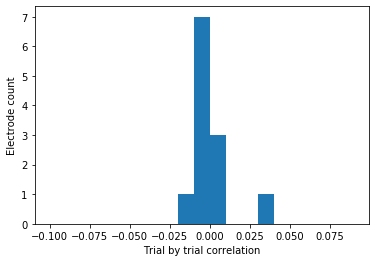

(array([0., 0., 0., 0., 0., 0., 3., 2., 2., 1., 0., 1., 0., 1., 0., 2., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95]),
 <a list of 39 Patch objects>)

Text(0.5, 0, 'Ripple rate (hz)')

Text(0, 0.5, 'Electrode count')

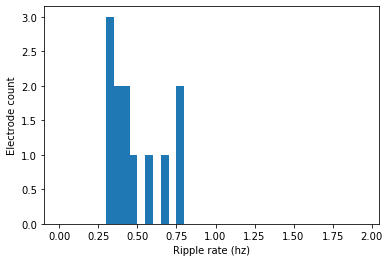

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([-3.50000000e-01, -3.25000000e-01, -3.00000000e-01, -2.75000000e-01,
        -2.50000000e-01, -2.25000000e-01, -2.00000000e-01, -1.75000000e-01,
        -1.50000000e-01, -1.25000000e-01, -1.00000000e-01, -7.50000000e-02,
        -5.00000000e-02, -2.50000000e-02,  3.33066907e-16,  2.50000000e-02,
         5.00000000e-02,  7.50000000e-02,  1.00000000e-01,  1.25000000e-01,
         1.50000000e-01,  1.75000000e-01,  2.00000000e-01,  2.25000000e-01,
         2.50000000e-01,  2.75000000e-01,  3.00000000e-01,  3.25000000e-01]),
 <a list of 27 Patch objects>)

Text(0.5, 0, 'Elec by elec correlation')

Text(0, 0.5, 'Electrode count')

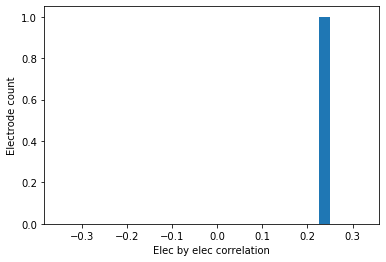

In [710]:
# to visualize the removal parameters

# np.array(trial_by_trial_correlation)
# np.array(elec_ripple_rate_array)
# np.array(elec_by_elec_correlation)
plt.hist(trial_by_trial_correlation,np.arange(-0.1,0.1,0.01)); xlabel('Trial by trial correlation'); ylabel('Electrode count'); show()
plt.hist(elec_ripple_rate_array,np.arange(0,2,0.05)); xlabel('Ripple rate (hz)'); ylabel('Electrode count'); show()
plt.hist(elec_by_elec_correlation,np.arange(-0.35,0.35,0.025)); xlabel('Elec by elec correlation'); ylabel('Electrode count'); show()

## Get start_array and select subfield if HPC for free recalls

In [246]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number
select_greater_than_rectime = 0          # select only recalls > this number
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions

# select for subfield if HPC
if select_subfield == True:
    location_selected = ['dg','ca1'] #['dg','ca1'] #'dg' # 'ca3' # 'dg' 'ca1' # sub 
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<=select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# gotta translate this to new frame as well from idxs in load step if selected subfield
if select_subfield == True: 
    location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
rectime_array = rectime_array[updated_recalls]
list_num_key = list_num_key[updated_recalls]

    
print('Got start_array with '+str(start_array.shape[0])+' trials!')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

Total electrodes loaded: 538
from 115 sessions from 57 subjects with trial nums:
[78. 78. 78. 78. 78. 51. 51. 51. 51. 51. 69. 69. 69. 69. 69. 69. 45. 45.
 45. 19.]
Trial sum = 25787.0
['left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'right ca1', 'right dg', 'right dg', 'right sub', 'right sub', 'right ca1', 'left sub', 'left dg', 'left ca1', 'left ca1']
Number of sub_sess names: 538
Got start_array with 12437 trials!


## List-level memory performance within SINGLE subject (*load from sub_df above*)

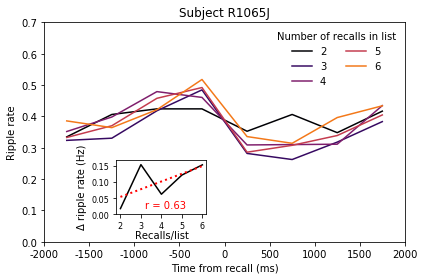

In [237]:
# do subjects show bigger ripple bump on lists they have more recalls?
   
unique_sessions = np.unique(session_name_array)
unique_recall_nums = np.unique(list_recall_num_array)
min_recall_num = np.min(unique_recall_nums)

plot_save = [] # list that will be appended for each unique recall_num
for i in range(len(unique_recall_nums)):
    plot_save.append([])

for session_name in unique_sessions:
    session_trials = session_name_array==session_name
    session_recall_nums = list_recall_num_array[session_trials]
    session_start_array = start_array[session_trials]
    
    for i,recall_num in enumerate(session_recall_nums):
        # index to 0 and append each start_array trials
        plot_save[recall_num-min_recall_num].append(session_start_array[i,:])
        
        
# visualize by plotting the binned average of each

stats_bin = 500 # time bin width in ms to test stats on

xr = np.arange(0,4000,500)+250

from matplotlib import cm
colormap = plt.cm.inferno # copper
colors = [colormap(i) for i in np.linspace(0, 0.7, len(plot_save))]

delta_ripple_rate = []

for i,num_recalls in enumerate(range(len(plot_save))):
    
    # bin it
    temp_binned_array = binBinaryArray(np.array(plot_save[num_recalls])[:,1:],stats_bin,sr_factor)
    delta_ripple_rate.append(np.mean(temp_binned_array[:,3])-np.mean(temp_binned_array[:,1]))

    plot(xr,np.mean(temp_binned_array,0),color=colors[i])

title('Subject '+sub)
ylabel('Ripple rate')
xlabel('Time from recall (ms)')
xticks(np.arange(0,4001,500),np.arange(-2000,2001,500))
gca().set_ylim(0,0.7)
gca().set_xlim(0,4000)
legend(unique_recall_nums,title='Number of recalls in list',ncol=2,frameon=False)

# plot delta ripple rate v. number of recalls

# for num_recalls in range(len(plot_save)):

axins = gca().inset_axes([0.2, 0.125, 0.25, 0.25])
    
axins.plot(unique_recall_nums,delta_ripple_rate,color=(0,0,0))
axins.tick_params(labelsize=8)

axins.set_ylabel(u'Δ ripple rate (Hz)')
axins.set_xlabel('Recalls/list')
axins.xaxis.set_label_coords(0.51,-0.29) 
axins.set_ylim(0,0.17)
gcf().tight_layout()
axins.set_xticks(np.arange(np.min(unique_recall_nums),np.max(unique_recall_nums)+0.01,1))
axins.set_yticks(np.arange(0,np.max(delta_ripple_rate),0.05))

reg = stats.linregress(unique_recall_nums,delta_ripple_rate) #slope, intercept, r_value
axins.annotate('r = '+str(np.round(reg.rvalue,3)),(3.2,0.02),color=(1,0,0))

xr = np.arange(np.min(unique_recall_nums),np.max(unique_recall_nums),0.01)
axins.plot(xr,xr*reg.slope+reg.intercept,marker='',linewidth=2,linestyle='dotted',color=[1,0,0])

a = 1;

## Do same but get correlations for each subject with at least min_trials (*load from half_df above*)

r = 0.587 for R1065J


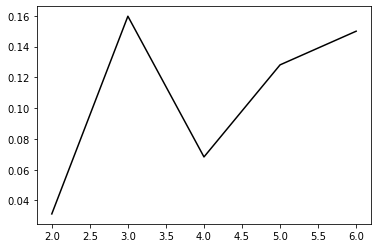

r = -0.886 for R1122E


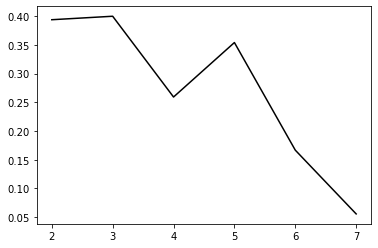

r = 0.578 for R1137E


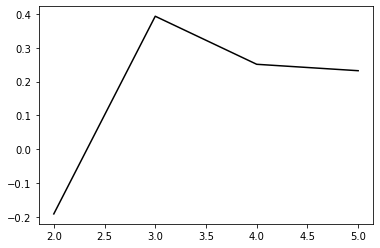

r = -0.386 for R1310J


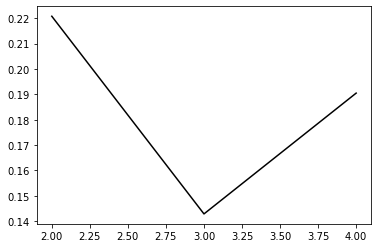

r = -0.138 for R1334T


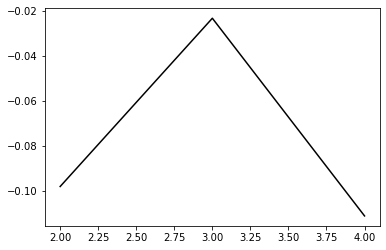

In [305]:
# do subjects show bigger ripple bump on lists they have more recalls?

min_trials_per_num_recalled = 35
min_trials = 250

corr_save = []

unique_subs = np.unique(subject_name_array)
for sub in unique_subs:
   
    sub_trials = subject_name_array==sub
    
    if sum(sub_trials) > min_trials:
        unique_sessions = np.unique(session_name_array[sub_trials])
        unique_recall_nums = np.unique(list_recall_num_array[sub_trials])
        unique_recall_nums = np.arange(np.min(unique_recall_nums),np.max(unique_recall_nums)+1) # so it doesn't skip numbers
        min_recall_num = np.min(unique_recall_nums)

        plot_save = [] # list that will be appended for each unique recall_num
        for i in range(len(unique_recall_nums)):
            plot_save.append([])

        for session_name in unique_sessions:
            session_trials = session_name_array==session_name
            session_recall_nums = list_recall_num_array[session_trials]
            session_start_array = start_array[session_trials]

            for i,recall_num in enumerate(session_recall_nums):
                # index to 0 and append each start_array trials
                plot_save[recall_num-min_recall_num].append(session_start_array[i,:])
                
        
                
        # make sure enough trials per bin to continue
        test_num = 0
        for i in range(len(plot_save)):
            if len(plot_save[i]) >= min_trials_per_num_recalled:
                test_num+=1
        if test_num != len(plot_save): # not enough trials in each bin
            continue


        # find corr for binned average of each

        stats_bin = 500 # time bin width in ms to test stats on

        delta_ripple_rate = []
        for i in range(len(plot_save)):

            # bin it
            temp_binned_array = binBinaryArray(np.array(plot_save[i]),stats_bin,sr_factor)
            delta_ripple_rate.append(np.mean(temp_binned_array[:,3])-np.mean(temp_binned_array[:,1]))

        reg = stats.linregress(unique_recall_nums,delta_ripple_rate) #slope, intercept, r_value
        corr_save.append(reg.rvalue)
        print('r = '+str(np.round(reg.rvalue,3))+' for '+sub)
        plot(unique_recall_nums,delta_ripple_rate,color=(0,0,0)); show()

[[]]

Text(0, 0.5, 'Recalls (#)')

Text(0.5, 1.0, 'Number of recalls X electrodes per subject')

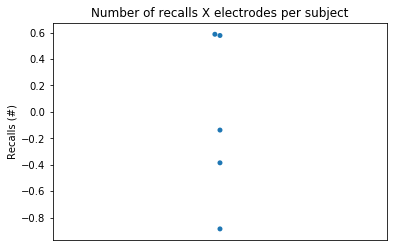

In [306]:
sb.swarmplot(data=corr_save) 
gca().set(xticks=[])
ylabel('Recalls (#)')
title('Number of recalls X electrodes per subject')
show()